# Group 1 Capstone Project Work
### Make sure to make / checkout your own branch before making changes

# Maddie Hince

In [1]:
import pandas as pd
import sqlite3
import warnings
warnings.filterwarnings('ignore')

conn = sqlite3.connect('zippedData/im.db')

In [2]:
ratings_df = pd.read_sql("""SELECT movie_ratings.movie_id, movie_ratings.averagerating, 
                                   movie_ratings.numvotes, movie_basics.primary_title, 
                                   movie_basics.start_year, movie_basics.genres 
                            FROM movie_ratings
                            JOIN movie_basics USING(movie_id)
                            WHERE movie_basics.start_year >= 2010""", conn)

In [3]:
ratings_df.dropna(how='any', axis=0, inplace=True)

In [4]:
def clean_genres(genres):
    genres = str(genres)
    genres_list = sorted(genres.lower().split(','))
    return ','.join(list(map(str, genres_list)))

In [5]:
ratings_df['genres'] = ratings_df['genres'].apply(clean_genres)
ratings_df.head()

,movie_id,averagerating,numvotes,primary_title,start_year,genres
0,tt0063540,7.0,77,Sunghursh,2013,"action,crime,drama"
1,tt0066787,7.2,43,One Day Before the Rainy Season,2019,"biography,drama"
2,tt0069049,6.9,4517,The Other Side of the Wind,2018,drama
3,tt0069204,6.1,13,Sabse Bada Sukh,2018,"comedy,drama"
4,tt0100275,6.5,119,The Wandering Soap Opera,2017,"comedy,drama,fantasy"


In [6]:
ratings_df['genres'].value_counts()
sorted_by_avg = ratings_df.groupby('genres').mean().sort_values(by='averagerating', ascending=False)

In [7]:
# filter out movie genres with less than 62 total votes
sorted_avg_higher_votes = sorted_by_avg[sorted_by_avg['numvotes'] >= 62].head(15)
sorted_avg_higher_votes.reset_index(inplace=True)

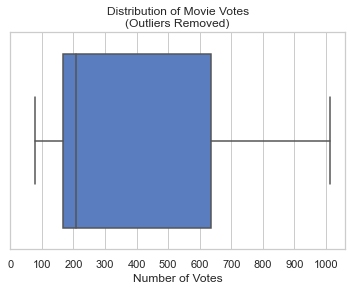

In [8]:
# visualizations
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style = 'whitegrid')
sns.set_color_codes('muted')

# outliers removed to improve quartile readability 
fig, ax = plt.subplots()
sns.boxplot(x = sorted_avg_higher_votes['numvotes'], showfliers=False, color='b');
ax.set_title('Distribution of Movie Votes\n(Outliers Removed)')
ax.set_xlabel('Number of Votes')
ax.set_xticks(range(0, 1051, 100));

In [9]:
# bar chart showing 15 highest-rated movie genres with more than 62 total votes
highest_rated_genres = sorted_avg_higher_votes[['genres', 'averagerating']]
highest_rated_genres['averagerating'] = highest_rated_genres['averagerating'].round(2)
highest_rated_genres

,genres,averagerating
0,"mystery,news,thriller",8.40
1,"documentary,music,war",8.30
2,"comedy,history,musical",8.30
3,"animation,crime,mystery",8.20
4,"romance,thriller,war",8.20
5,"comedy,musical,western",8.20
6,"animation,documentary,mystery",8.20
7,"documentary,fantasy,horror",8.10
8,"animation,crime,documentary",8.07
9,"documentary,drama,musical",8.05


In [10]:
# make count of each of these individual genres in dictionary
top_genres = {}
for genre in sorted_avg_higher_votes['genres'].value_counts().index:
    genre_list = genre.split(',')
    for item in genre_list:
        if item not in top_genres:
            top_genres[item] = 1
        elif item in top_genres:
            top_genres[item] += 1
top_genres = dict(sorted(top_genres.items(), key = lambda x: x[1], reverse=True))

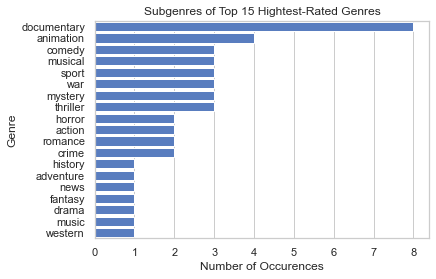

In [11]:
# bar chart showing most-used subgenres within top 15 highest-rated 
# movie genres
fig, ax = plt.subplots()
sns.barplot(x = list(top_genres.values()), y = list(top_genres.keys()), color = 'b');
ax.set_title('Subgenres of Top 15 Hightest-Rated Genres')
ax.set_xlabel('Number of Occurences')
ax.set_ylabel('Genre');

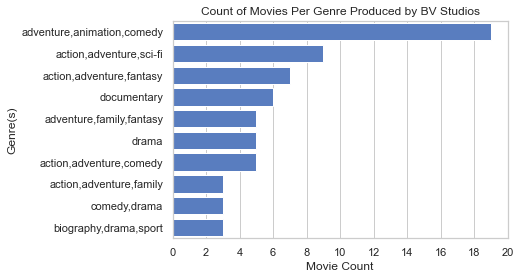

In [12]:
# dataframe with movie titles and studio
movie_gross_df = pd.read_csv('zippedData/bom.movie_gross.csv.gz')
movie_gross_df['title'] = movie_gross_df['title'].str.lower()

# dataframe from database with movie titles and genres
movie_basics_df = pd.read_sql("""SELECT *
                                 FROM movie_basics
                                 WHERE start_year >= 2010""", conn)
movie_basics_df['primary_title'] = movie_basics_df['primary_title'].str.lower()

# inner join dataframes on title (movie_gross_df), primary_title (movie_basics_df)
movie_genre_studio_df = pd.merge(movie_gross_df, movie_basics_df, 
                                 left_on='title', right_on='primary_title',
                                 how='inner')
# drop movies with no genres
movie_genre_studio_df.dropna(subset=['genres'], inplace=True)
# clean genre string for each row
movie_genre_studio_df['genres'] = movie_genre_studio_df['genres'].apply(clean_genres)

# put movies from highest-performing studio into a dataframe
bv_studio_movies = movie_genre_studio_df[movie_genre_studio_df['studio'] == 'BV']

# bar chart showing number of movies per genre for BV studios
fig, ax = plt.subplots()
sns.countplot(data=bv_studio_movies, y='genres', 
              order=bv_studio_movies['genres'].value_counts().iloc[:10].index,
              color = 'b')
ax.set_xticks(range(0,21,2))
ax.set_title('Count of Movies Per Genre Produced by BV Studios')
ax.set_xlabel('Movie Count')
ax.set_ylabel('Genre(s)');

# Cat Murad

# Elijah Soba

Working on: Gross dataset and Movie Budgets dataset

In [43]:
# Import statements
import sqlite3 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import datetime
sns.set_style('darkgrid')
sns.set_context('notebook')
sns.set()

# Gross Dataset

In [44]:
# Define filepath & read in the data 
filepath = 'zippedData/bom.movie_gross.csv.gz'
movie_gross_df = pd.read_csv(filepath)

In [45]:
# Take a prelimary look at the data
movie_gross_df.head()

,title,studio,domestic_gross,foreign_gross,year
0,Toy Story 3,BV,415000000.0,652000000,2010
1,Alice in Wonderland (2010),BV,334200000.0,691300000,2010
2,Harry Potter and the Deathly Hallows Part 1,WB,296000000.0,664300000,2010
3,Inception,WB,292600000.0,535700000,2010
4,Shrek Forever After,P/DW,238700000.0,513900000,2010


In [46]:
# Take a look at the data frame information
movie_gross_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3387 entries, 0 to 3386
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           3387 non-null   object 
 1   studio          3382 non-null   object 
 2   domestic_gross  3359 non-null   float64
 3   foreign_gross   2037 non-null   object 
 4   year            3387 non-null   int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 132.4+ KB


From looking at the information we can see immediately that there are a couple things wrong with the data:
- There are missing values in studio, domestic gross, and foreign gross
- Foreign gross is represented as an object instead of a float
- Year is represented as an integer, but it is probably better to have it as a datetime object

## Cleaning Step 1: Change Dtypes

We want to be sure that all of the dtypes that we are working with are acurately represented by the correct python type that we expect. Looking at the data frame information, we see that `foreign_gross` is represented as an `object` when we would expect to see it as a `float`. We can use Pandas to change this data to meet our data type expectations

In [47]:
# Lets recast foregin_gross as a float 
str_to_float = lambda x: float(str(x).replace(',', ''))
movie_gross_df['foreign_gross'] = movie_gross_df['foreign_gross'].map(str_to_float)

In [48]:
# Lets test to see if the data type actually changed 
assert movie_gross_df['foreign_gross'].dtype  == np.float64

## Cleaning Step 2: Handle Missing Data

First, we look at the `studio` column because that is the column with the least amount of missing data. In addition, it is the easiest to deal with because missing values can be replaced with 'IND' standing for independent film 

Next, we look at the `domestic_gross` column which is one of the primary sources of data in this table. We check to see what percentage of the data is corrupted, and if it is small we will simply delete those rows. If it is not, we will explore data imputation techniques

Finally, we look at the `foreign_gross` column and perform the same analysis as the `domestic_gross`. Seeing that it is a big chunk of the data, we will most likely have to impute. Imputation can be done by looking at a summary statistic of the percent change between `foreign_gross` and `domestic_gross` and using that to make up a value for `foreign gross` as a function of `domestic_gross`. 


In [50]:
# Lets replace missing studios with 'IND' representing independent
movie_gross_df['studio'] = movie_gross_df['studio'].fillna('IND')

In [51]:
# Test to see if there are any missing values in the studio column
assert movie_gross_df['studio'].isna().sum() == 0

In [52]:
# Lets see what percentage of the domestic gross data is missing 
pct_missing_dom = movie_gross_df.domestic_gross.isna().sum()/len(movie_gross_df.title)
print(f'Missing domestic gross data represents {pct_missing_dom*100}% of the data')

Missing domestic gross data represents 0.8266902863891349% of the data


In [53]:
# The missing data is a very small fraction, so lets delete those rows
movie_gross_df = movie_gross_df.dropna(axis=0, subset=['domestic_gross'])

In [54]:
# Test to see whether that deletion worked
assert movie_gross_df['domestic_gross'].isna().sum() == 0

In [55]:
# Lets see what percentage of the foreign gross data is missing 
pct_missing_dom = movie_gross_df.foreign_gross.isna().sum()/len(movie_gross_df.title)
print(f'Missing domestic gross data represents {pct_missing_dom*100}% of the data')

Missing domestic gross data represents 40.190532896695444% of the data


In [56]:
# That is too much, so lets find the median pct change between domestic and foreign films
med_pct_change = ((movie_gross_df['foreign_gross'] - movie_gross_df['domestic_gross'])/movie_gross_df['domestic_gross']).median()
print(med_pct_change)

0.6315266036797613


In [57]:
# Now that we have the median % change, lets impute the missing foreign values 
impute_change = movie_gross_df['domestic_gross'] + (movie_gross_df['domestic_gross'] * med_pct_change)
movie_gross_df['foreign_gross'] = movie_gross_df['foreign_gross'].fillna(impute_change)

In [58]:
# Test that we now have no more NaN values in the data 
assert movie_gross_df['foreign_gross'].isna().sum() == 0

In [59]:
# Finally, test to see if there are any missing values anywhere in the data 
assert movie_gross_df.isna().sum().sum() == 0

## Data Exploration: 

Now that we do not have any more missing values, we can begin data exploration. Because we want to see what contributes to a successful movie, we can look at how gross changes depending on different factors such as year and studio. In addition, we can explore the relationships within and between these variables to see if any meaningful conclusions can be drawn.

## Step 1: Explore Values in the Gross Columns

In [60]:
# Lets feature engineer a new feature that can be useful to our understanding of gross as a whole
movie_gross_df['total_gross'] = movie_gross_df['foreign_gross'] + movie_gross_df['domestic_gross']

In [61]:
# Test to see whether that column was successfully created 
assert 'total_gross' in movie_gross_df.columns

In [62]:
# Lets take a look at that newly created column 
movie_gross_df['total_gross'].sort_values()

1476    2.631527e+02
2757    7.894580e+02
2756    7.894580e+02
2321    7.894580e+02
3078    1.052611e+03
            ...     
2758    1.332600e+09
328     1.341500e+09
3080    1.347000e+09
1875    1.405400e+09
727     1.518900e+09
Name: total_gross, Length: 3359, dtype: float64

In [63]:
# Lets normalize the data to millions to make numbers more manageable
movie_gross_df['total_gross'] = movie_gross_df['total_gross']/1000000
movie_gross_df['domestic_gross'] = movie_gross_df['domestic_gross']/1000000
movie_gross_df['foreign_gross'] = movie_gross_df['foreign_gross']/1000000

In [64]:
# Lets take another look 
movie_gross_df['total_gross'].sort_values()

1476       0.000263
2757       0.000789
2756       0.000789
2321       0.000789
3078       0.001053
           ...     
2758    1332.600000
328     1341.500000
3080    1347.000000
1875    1405.400000
727     1518.900000
Name: total_gross, Length: 3359, dtype: float64

In [65]:
# Lets see what movie grossed the most 
movie_gross_df.loc[movie_gross_df['total_gross'].idxmax(), :]

title             Marvel's The Avengers
studio                               BV
domestic_gross                    623.4
foreign_gross                     895.5
year                               2012
total_gross                      1518.9
Name: 727, dtype: object

In [66]:
# Lets see what film did the best in terms of domestic gross 
movie_gross_df.loc[movie_gross_df['domestic_gross'].idxmax(), :]

title             Star Wars: The Force Awakens
studio                                      BV
domestic_gross                           936.7
foreign_gross                        0.0011316
year                                      2015
total_gross                            936.701
Name: 1872, dtype: object

In [67]:
# Lets see what film did the best in terms of foreign gross 
movie_gross_df.loc[movie_gross_df['foreign_gross'].idxmax(), :]

title             Harry Potter and the Deathly Hallows Part 2
studio                                                     WB
domestic_gross                                            381
foreign_gross                                           960.5
year                                                     2011
total_gross                                            1341.5
Name: 328, dtype: object

Text(0.5, 1.0, 'Distribution of Total Gross Data')

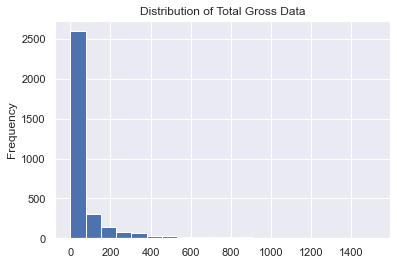

In [68]:
# Lets visualize the distribution of total gross data 
fig, axs = plt.subplots()
movie_gross_df['total_gross'].plot.hist(bins=20, ax=axs)
axs.set_title('Distribution of Total Gross Data')

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


Text(0, 0.5, 'Foreign Gross in Millions')

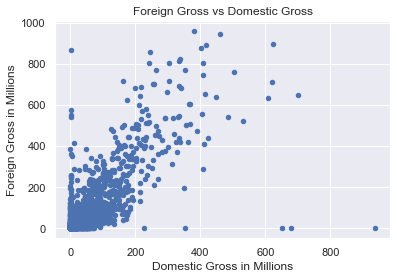

In [69]:
# Lets visually see the correlation between domestic and foreign gross
fig, axs = plt.subplots()
movie_gross_df.plot.scatter('domestic_gross', 'foreign_gross', ax=axs)
axs.set_title('Foreign Gross vs Domestic Gross')
axs.set_xlabel('Domestic Gross in Millions')
axs.set_ylabel('Foreign Gross in Millions')

In [70]:
# Lets actually see what the correlation is between the two
corr = np.corrcoef(movie_gross_df['domestic_gross'], movie_gross_df['foreign_gross'])[0][1]
print(f'The correlation between the two variables is {corr}')

The correlation between the two variables is 0.7928984029704482


By looking at the scatter plot, we can notice two main things. 
- There is a positive correlation between domestic gross and foreign gross which is expected 
- There are a lot of data points that seemingly have 0 domestic gross and non-zero foreign gross (and vice versa)

In [71]:
# Lets quickly verify that there are no films with 0 domestic gross 
assert movie_gross_df[movie_gross_df['domestic_gross'] == 0.0].sum()[0] == 0

In [72]:
# Lets quickly verify that there are no films with 0 domestic gross 
assert movie_gross_df[movie_gross_df['foreign_gross'] == 0.0].sum()[0] == 0

## Step 2: Looking at the Gross Data over time

In [73]:
# Lets see which years are represented in the data
movie_gross_df['year'].value_counts()

2015    449
2016    433
2011    397
2012    393
2014    391
2013    345
2010    323
2017    320
2018    308
Name: year, dtype: int64

Text(0, 0.5, 'Domestic Gross in Millions')

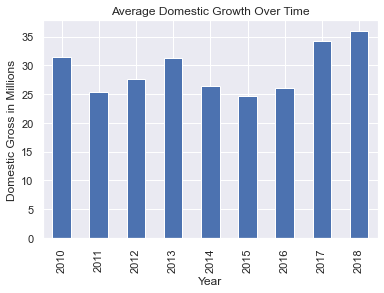

In [75]:
# Lets see how the average domestic gross varied over the years 
fig, axs = plt.subplots()
movie_gross_df.groupby('year').mean()['domestic_gross'].plot.bar(ax=axs)
axs.set_title('Average Domestic Growth Over Time')
axs.set_xlabel('Year')
axs.set_ylabel('Domestic Gross in Millions')

Text(0, 0.5, 'Foreign Gross in Millions')

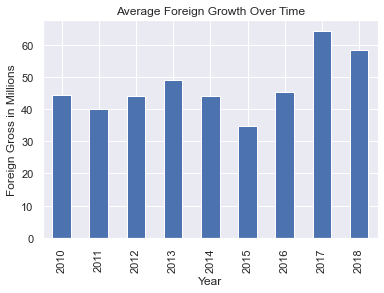

In [76]:
# Lets see how the average foreign gross varied over the years 
fig, axs = plt.subplots()
movie_gross_df.groupby('year').mean()['foreign_gross'].plot.bar(ax=axs)
axs.set_title('Average Foreign Growth Over Time')
axs.set_xlabel('Year')
axs.set_ylabel('Foreign Gross in Millions')

Text(0, 0.5, 'Total Gross in Millions')

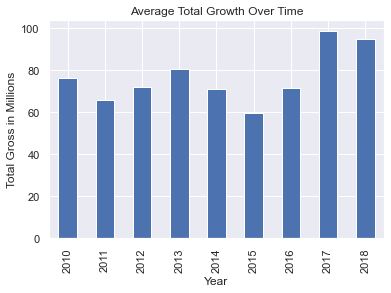

In [77]:
# Lets see how the average total gross varied over the years 
fig, axs = plt.subplots()
movie_gross_df.groupby('year').mean()['total_gross'].plot.bar(ax=axs)
axs.set_title('Average Total Growth Over Time')
axs.set_xlabel('Year')
axs.set_ylabel('Total Gross in Millions')

## Step 3: How Well Did Specific Studios Do?

In [78]:
# Lets inspect all of the studios to see if there is any duplicates w/misspellings
movie_gross_df['studio'].value_counts().sort_values(ascending=False)

IFC      166
Uni.     147
WB       140
Magn.    136
Fox      136
        ... 
BSC        1
WOW        1
Linn       1
Zee        1
FEF        1
Name: studio, Length: 256, dtype: int64

In [79]:
# Lets only look at studios that have more than 50 movies 
studio_50 = movie_gross_df.groupby("studio").filter(lambda x: len(x) > 50)

Text(0.5, 0, 'Studio')

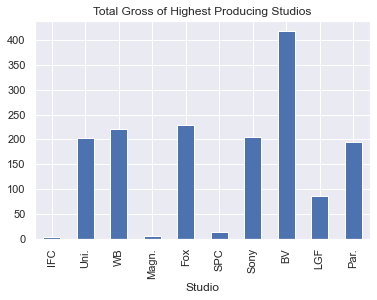

In [80]:
# Lets see how the top 10 most producing studios did in terms of average total gross
fig, axs = plt.subplots()
top10_prod = list(studio_50['studio'].value_counts().sort_values(ascending=False)[:10].index)
studio_50.groupby('studio').mean()['total_gross'].loc[top10_prod].plot.bar(ax=axs)
axs.set_title('Total Gross of Highest Producing Studios')
axs.set_xlabel('Studio')

This visualization tells us that just because a studio produces a lot of movies does not mean they will gross the most 

Text(0.5, 0, 'Studio')

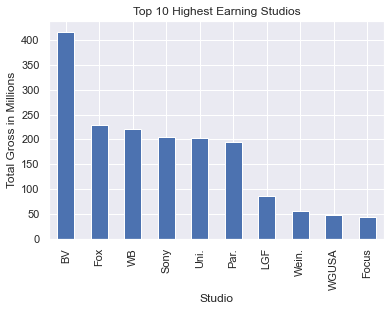

In [82]:
# Instead, lets use the top 10 highest earners
fig, axs = plt.subplots()
studio_50.groupby('studio').mean()['total_gross'].sort_values(ascending=False)[:10].plot.bar(ax = axs)
axs.set_title('Top 10 Highest Earning Studios')
axs.set_ylabel('Total Gross in Millions')
axs.set_xlabel('Studio')


In [83]:
# Lets look at the movies that studio HC has done
movie_gross_df[movie_gross_df['studio'] == 'BV']

,title,studio,domestic_gross,foreign_gross,year,total_gross
0,Toy Story 3,BV,415.0,652.0,2010,1067.0
1,Alice in Wonderland (2010),BV,334.2,691.3,2010,1025.5
7,Tangled,BV,200.8,391.0,2010,591.8
13,Tron Legacy,BV,172.1,228.0,2010,400.1
15,Prince of Persia: The Sands of Time,BV,90.8,245.6,2010,336.4
...,...,...,...,...,...,...
3101,Solo: A Star Wars Story,BV,213.8,179.2,2018,393.0
3107,Mary Poppins Returns,BV,172.0,177.6,2018,349.6
3120,Disney's Christopher Robin,BV,99.2,98.5,2018,197.7
3122,The Nutcracker and the Four Realms,BV,54.9,119.1,2018,174.0


Potential Recommendation: Movies that are produced by BV are on average much higher earners than any other studio, so we suggest to draw inspiration from the movies they have created. 

# Budget Dataset

In [84]:
# Load in the data into pandas
filepath = 'zippedData/tn.movie_budgets.csv.gz'
budget_df = pd.read_csv(filepath)

In [85]:
# Lets take a glimpse at the data set 
budget_df.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


In [86]:
# Take a look at the data frame information
budget_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 5782 non-null   int64 
 1   release_date       5782 non-null   object
 2   movie              5782 non-null   object
 3   production_budget  5782 non-null   object
 4   domestic_gross     5782 non-null   object
 5   worldwide_gross    5782 non-null   object
dtypes: int64(1), object(5)
memory usage: 271.2+ KB


From looking at the information we can immediately see a few important things:
- There are no missing values
- The release date is a string and not a datetime object 
- All of the numerical columns are strings instead of floats
- We have an id column


## Data Cleaning 

Because there is no missing data, our cleaning step will involve changing the dtype of all the variables to match our expectations, checking to see if there are any placeholder values that replace NaNs, and normalizing the data to the millions so that the numbers are more manageable

In [87]:
# Lets define a function that will parse through a string of $xxx,xxx,xxx and turn it into a float
money_to_float = lambda x: float(x.replace('$','').replace(',',''))

In [88]:
# Lets test to make sure this function is behaving the way that we anticipate
assert money_to_float('$1,000') == 1000

In [89]:
# Update the dtype of the production_budget column 
budget_df['production_budget'] = budget_df['production_budget'].map(money_to_float)

In [90]:
# Update the dtype of the domestic_gross column 
budget_df['domestic_gross'] = budget_df['domestic_gross'].map(money_to_float)

In [91]:
# Update the dtype of the worldwide_gross column 
budget_df['worldwide_gross'] = budget_df['worldwide_gross'].map(money_to_float)

In [92]:
# Test to make sure it worked
assert budget_df['production_budget'].dtype == np.float64

In [93]:
# Lets make the release date an int dtype that only has the year
budget_df['release_date'] = pd.to_datetime(budget_df['release_date']).dt.year

In [94]:
# Test to make sure the dtype is now correct
assert budget_df['release_date'].dtype == np.int64

In [95]:
# Lets see if any of the gross values are equal to 0, a number that does not make sense in this context
budget_df[budget_df['domestic_gross'] == 0]

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
194,95,2020,Moonfall,150000000.0,0.0,0.0
479,80,2017,Bright,90000000.0,0.0,0.0
480,81,2019,Army of the Dead,90000000.0,0.0,0.0
535,36,2020,Call of the Wild,82000000.0,0.0,0.0
617,18,2012,AstÃ©rix et ObÃ©lix: Au service de Sa MajestÃ©,77600000.0,0.0,60680125.0
...,...,...,...,...,...,...
5761,62,2014,Stories of Our Lives,15000.0,0.0,0.0
5764,65,2007,Tin Can Man,12000.0,0.0,0.0
5771,72,2015,Family Motocross,10000.0,0.0,0.0
5777,78,2018,Red 11,7000.0,0.0,0.0


In [96]:
# Lets see if any of the production values are equal to 0, a number that does not make sense in this context
budget_df[budget_df['production_budget'] == 0]

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross


We see that there are indeed values that can be considered corrupted in the gross columns, but not in the production column. What we can do with this is see what percentage of data is 0 from the domestic_gross and worldwide_gross. If it is a small percentage, we can just drop the values but if it is a large percentage we can find a way to impute it. 

In [97]:
# Lets see the profile of our "missing" gross values
either_miss = len(budget_df[(budget_df['domestic_gross'] == 0) | (budget_df['worldwide_gross'] == 0)])
both_miss = len(budget_df[(budget_df['domestic_gross'] == 0) & (budget_df['worldwide_gross'] == 0)])
just_dom = len(budget_df[budget_df['domestic_gross'] == 0])
just_world = len(budget_df[budget_df['worldwide_gross'] == 0])
len_dataset = len(budget_df['domestic_gross'])
print(f'Number of missing gross values from either column {either_miss}')
print(f'Number of missing gross values from both columns {both_miss}')
print(f'Number of missing gross values from just domestic {just_dom}')
print(f'Number of missing gross values from just worldwide {just_world}')
print(f'Number of items in the entire dataset {len_dataset}')

Number of missing gross values from either column 548
Number of missing gross values from both columns 367
Number of missing gross values from just domestic 548
Number of missing gross values from just worldwide 367
Number of items in the entire dataset 5782


In [98]:
# Because there are numbers with 0 domestic and worldwide gross, lets see what fraction of the dataset it is
pct_0_dom = just_dom/len_dataset
print(f'Percentage of the data that is missing from the domestic column {pct_0_dom*100}')
pct_0_world = just_world/len_dataset
print(f'Percentage of the data that is missing from the worldwide column {pct_0_world*100}')

Percentage of the data that is missing from the domestic column 9.47768938083708
Percentage of the data that is missing from the worldwide column 6.347284676582497


In [99]:
# Both values are < 10% of the data, which for now we will consider as small enough to just drop
budget_df = budget_df[budget_df['domestic_gross'] != 0]

In [100]:
# Test to make sure we dropped correctly
assert len(budget_df[budget_df['domestic_gross'] == 0]) == 0
assert len(budget_df[budget_df['worldwide_gross'] == 0]) == 0

In [101]:
# Finally, we can normalize monetary columns to the millions 
budget_df['production_budget'] = budget_df['production_budget']/1000000
budget_df['domestic_gross'] = budget_df['domestic_gross']/1000000
budget_df['worldwide_gross'] = budget_df['worldwide_gross']/1000000

## Data Exploration

Now that all of the data types are what we expect, we will explore the data. First, we look at the `id` column to see what relevance it has to the dataset. Then, we will create some features to explore the relationship between a movies budget and how much it grosses both domestically and worldwide. Finally, we will look at the data over time to see if older movies would give our clients outdated information. 

## Step 1: What do the ID's mean?

In [102]:
# Lets look at the value counts for the id's 
budget_df['id'].value_counts()

79    56
77    55
47    55
78    55
37    55
      ..
63    49
55    49
62    49
95    49
56    47
Name: id, Length: 100, dtype: int64

It looks like each of the ID's have the same number of entries meaning that there could be something more to them than it seems. Lets take a quick look at some of the respective index values to see if maybe groups have something in common

In [103]:
# Investigate group 4
budget_df[budget_df['id'] == 4].head(10)

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
3,4,2015,Avengers: Age of Ultron,330.6,459.005868,1403.013963
103,4,2009,Monsters vs. Aliens,175.0,198.351526,381.687380
203,4,2016,Ghostbusters,144.0,128.350574,229.008658
303,4,1999,Star Wars Ep. I: The Phantom Menace,115.0,474.544677,1027.044677
403,4,2018,Mortal Engines,100.0,15.951040,85.287417
503,4,2006,Open Season,85.0,85.105259,191.932158
603,4,1997,The Postman,80.0,17.650704,20.841123
703,4,2003,S.W.A.T.,70.0,116.877597,207.154748
803,4,2012,Resident Evil: Retribution,65.0,42.345531,240.647629
903,4,2013,Gangster Squad,60.0,46.000903,104.100903


In [104]:
# Investigate group 8
budget_df[budget_df['id'] == 8].head(10)

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
7,8,2007,Pirates of the Caribbean: At Worldâs End,300.0,309.420425,963.420425
107,8,2008,The Mummy: Tomb of the Dragon Emperor,175.0,102.491776,405.760225
207,8,1998,Armageddon,140.0,201.578182,554.600000
307,8,2013,The Wolverine,115.0,132.556852,416.456852
407,8,2019,The LEGO Movie 2: The Second Part,99.0,105.806508,190.325698
507,8,2006,The Holiday,85.0,63.280000,205.190324
607,8,2005,A Sound of Thunder,80.0,1.900451,6.300451
707,8,1997,Hercules,70.0,99.112101,250.700000
807,8,1996,The Long Kiss Goodnight,65.0,33.447612,33.447612
907,8,2010,Edge of Darkness,60.0,43.313890,82.812456


The only similarity between the two groups is that production budgets seem to line up in similar decreasing fashions. This most likely means all of this data was ordered by production_budget and each group was concatenated with each other to make one big dataset. Until we receive any new information, let us just not worry about the ID column. 

## Step 2: How do Old Movies Compare to Newer Movies?

In [105]:
# First, lets look at the highest grossing films worldwide and domestic
print(budget_df.loc[budget_df['worldwide_gross'].idxmax(), :])
print(budget_df.loc[budget_df['domestic_gross'].idxmax(), :])

id                         1
release_date            2009
movie                 Avatar
production_budget        425
domestic_gross       760.508
worldwide_gross      2776.35
Name: 0, dtype: object
id                                                      6
release_date                                         2015
movie                Star Wars Ep. VII: The Force Awakens
production_budget                                     306
domestic_gross                                    936.662
worldwide_gross                                   2053.31
Name: 5, dtype: object


In [106]:
# Lets look at the value count of all the years
budget_df['release_date'].value_counts().sort_index(ascending=False)

2019     44
2018    137
2017    149
2016    192
2015    208
       ... 
1929      1
1925      2
1920      1
1916      1
1915      1
Name: release_date, Length: 92, dtype: int64

Text(0, 0.5, 'Count')

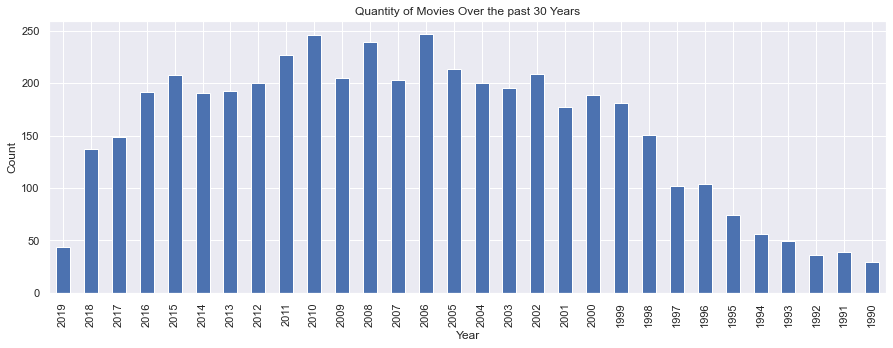

In [107]:
# Already we can see some years have very little movies. Let us filter the top 30 
fig, axs = plt.subplots(figsize=(15,5))
budget_df['release_date'].value_counts().sort_index(ascending=False)[:30].plot.bar(ax = axs)
axs.set_title('Quantity of Movies Over the past 30 Years')
axs.set_xlabel('Year')
axs.set_ylabel('Count')

It seems like after 1997 there was a big boom in the number of movies that were made. From the standpoint of quantity of movies, there is no indication that we should only look at a more recent subset. Lets check out how much movies grossed based on year starting with the year that the boom happened

In [108]:
# Lets filter out the older dates
budget_df = budget_df[budget_df['release_date'] > 1997]

In [109]:
# Check our new filtered years
budget_df['release_date'].value_counts()

2006    247
2010    246
2008    239
2011    227
2005    214
2002    209
2015    208
2009    205
2007    203
2004    200
2012    200
2003    195
2013    193
2016    192
2014    191
2000    189
1999    181
2001    177
1998    151
2017    149
2018    137
2019     44
Name: release_date, dtype: int64

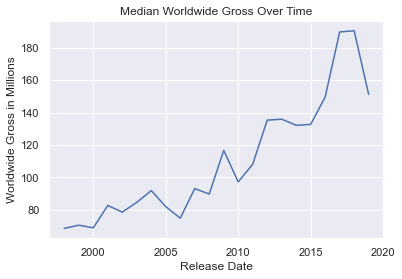

In [112]:
# Lets groupby the year and see the median amount movies grossed worldwide
fig, axs = plt.subplots()
budget_df.groupby('release_date').mean().reset_index().plot('release_date', 'worldwide_gross', ax = axs)
axs.set_title('Median Worldwide Gross Over Time')
axs.set_xlabel('Release Date')
axs.set_ylabel('Worldwide Gross in Millions')
axs.get_legend().remove()

From the graph, it is obvious that there is an upward trend in worldwide gross over the years. Because we know our other dataset starts movie data at 2010 and after 2010 the worldwide gross is higher than the years prior by a substantial margin, we can consider deleting those years prior.

In [113]:
# Remove the years before 2010 where we saw a jump in worldwide gross
budget_df = budget_df[budget_df['release_date'] >= 2010]

## Step 3: How does Production Budget Affect Gross?

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


Text(0, 0.5, 'Worldwide Gross in Millions')

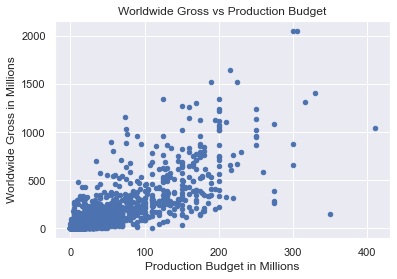

In [114]:
# Lets start off by checking the scatter plot of budget and worldwide gross to gain intuition
fig, axs = plt.subplots()
budget_df.plot.scatter('production_budget', 'worldwide_gross', ax = axs)
axs.set_title('Worldwide Gross vs Production Budget')
axs.set_xlabel('Production Budget in Millions')
axs.set_ylabel('Worldwide Gross in Millions')

In [115]:
# To be more concrete, lets also print out the correlation coefficient 
corr = np.corrcoef(budget_df['production_budget'], budget_df['worldwide_gross'])[0][1]
print(f'The correlation between production budget and worldwide gross is {corr}')

The correlation between production budget and worldwide gross is 0.7872721892906527


From the scatter plot, it looks like there is a positive correlation (.787) but not as much as we would expect. This indicates that spending more money on a film may not mean more gross 

Text(0, 0.5, 'Worldwide Gross in Millions')

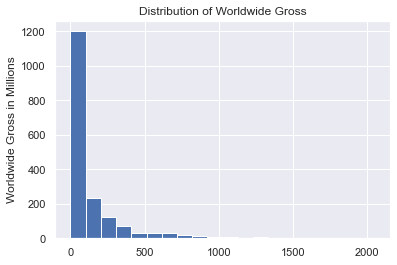

In [116]:
# Lets look at the distribution of worldwide gross to see how it is shaped 
fig, axs = plt.subplots()
budget_df['worldwide_gross'].plot.hist(bins=20, ax=axs)
axs.set_title('Distribution of Worldwide Gross')
axs.set_ylabel('Worldwide Gross in Millions')

Text(0.5, 1.0, 'Box Plot of Worldwide Gross Data')

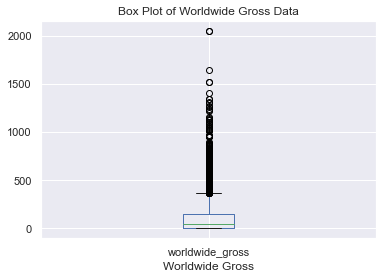

In [117]:
# Lets also add a box and whisker because the data is heavily skewed 
fig, axs = plt.subplots()
budget_df['worldwide_gross'].plot.box(ax=axs)
axs.set_xlabel('Worldwide Gross')
axs.set_title('Box Plot of Worldwide Gross Data')

Text(0.5, 0, 'Worldwide Gross')

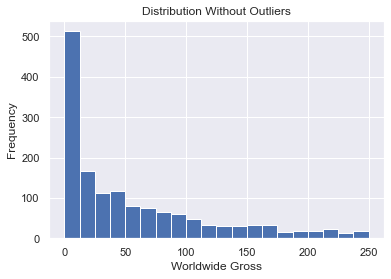

In [118]:
# Lets also redo this to exclude all of the outliers to get a better visualization 
fig, axs = plt.subplots()
budget_df[budget_df['worldwide_gross'] <= 250]['worldwide_gross'].plot.hist(bins=20, ax=axs)
axs.set_title('Distribution Without Outliers')
axs.set_xlabel('Worldwide Gross')

Text(0.5, 1.0, 'Boxplot Without Outliers')

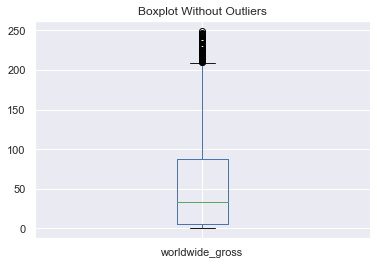

In [119]:
# Same with the box plot 
fig,axs = plt.subplots()
budget_df[budget_df['worldwide_gross'] <= 250]['worldwide_gross'].plot.box(ax = axs)
axs.set_title('Boxplot Without Outliers')

It seems like a majority of films fall into the same bucket, but we want to give a suggestions that will get our movie studio into the tail end of the distribution. Lets see if the production budget can give us more information related to this

In [120]:
# Lets define a feature called budget to gross ratio 
budget_df['bg_ratio'] = budget_df['worldwide_gross']/budget_df['production_budget']
budget_df.bg_ratio.head()

1    2.546673
2    0.427892
3    4.243841
4    4.153696
5    6.710167
Name: bg_ratio, dtype: float64

This ratio can be interpreted as "for every dollar spent on production, how much did it gross worldwide?"

Text(0.5, 0, 'Box Office to Budget Ratio')

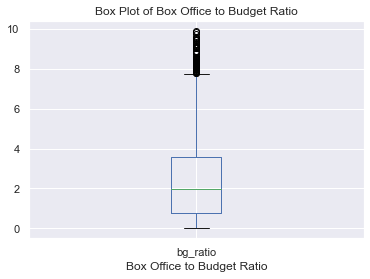

In [122]:
# Again, lets filter out some of these outliers to get a better picture of the distribution
fig,axs = plt.subplots()
budget_df[budget_df['bg_ratio'] < 10]['bg_ratio'].plot.box(ax=axs)
axs.set_title('Box Plot of Box Office to Budget Ratio')
axs.set_xlabel('Box Office to Budget Ratio')

Text(0.5, 0, 'Box Office to Budget Ratio')

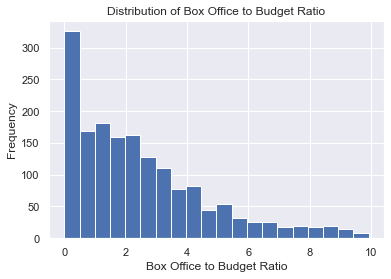

In [123]:
# Same with the histogram
fig,axs = plt.subplots()
budget_df[budget_df['bg_ratio'] < 10]['bg_ratio'].plot.hist(bins=20, ax=axs)
axs.set_title('Distribution of Box Office to Budget Ratio')
axs.set_xlabel('Box Office to Budget Ratio')

Text(0.5, 0, 'Box Office to Gross Ratio')

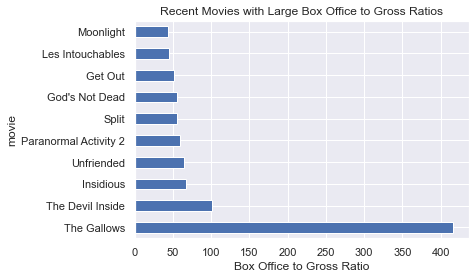

In [124]:
# Lets see the top 10 best films in terms of bg_ratio
fig, axs = plt.subplots()
budget_df['movie'] = budget_df['movie'].map(lambda x: x.replace('Godâs', "God's"))
budget_df.sort_values(by='bg_ratio', ascending=False)[:10].plot.barh('movie', 'bg_ratio', ax = axs, legend='Box Office to Gross Ratio')
axs.set_title('Recent Movies with Large Box Office to Gross Ratios')
axs.get_legend().remove()
axs.set_xlabel('Box Office to Gross Ratio')

Potential Recommendation: Look at these movies and see what makes them so profitable 

In [125]:
# Lets give some ordinality to our budgets to define low budget and high budget movies
avg_budget = budget_df['production_budget'].mean()
avg_budget

42.87490355344152

In [126]:
# Create a column that represents high budget and low budget movies
budget_df['high_budget'] = (budget_df['production_budget'] > avg_budget).astype(int).map({1: 'High Budget', 0:'Low Budget'})

Text(0, 0.5, 'Box Office to Gross Ratio')

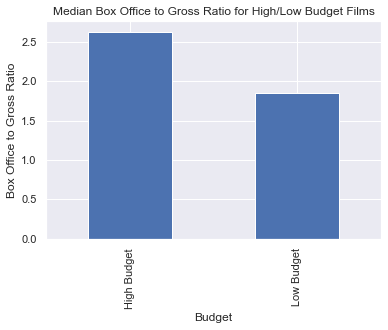

In [127]:
# Lets see the average and median bg_ratio for high budget and low budget films
fig, axs = plt.subplots()
budget_df.groupby('high_budget').median()['bg_ratio'].plot.bar(ax=axs)
axs.set_title('Median Box Office to Gross Ratio for High/Low Budget Films')
axs.set_xlabel('Budget')
axs.set_ylabel('Box Office to Gross Ratio')

<AxesSubplot:xlabel='high_budget'>

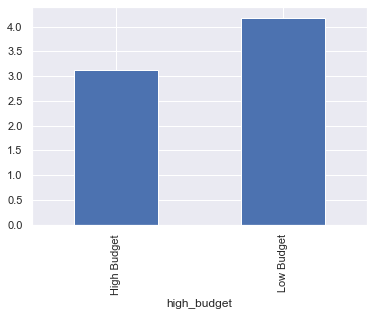

In [128]:
budget_df.groupby('high_budget').mean()['bg_ratio'].plot.bar() 

In [129]:
# Lets take a look at the variances
budget_df.groupby('high_budget').std()

,id,release_date,production_budget,domestic_gross,worldwide_gross,bg_ratio
high_budget,,,,,,
High Budget,29.039698,2.690428,59.838864,120.784789,324.756359,2.287961
Low Budget,28.111439,2.613051,12.233320,33.501665,68.331144,13.629455


Potential Recommendation: High budget movies have a very low bg_ratio standard deviation meaning that they are more consistent. It might be better to do a higher budget movie instead of lower budget because it is a lot more hit or miss 

In [130]:
# To be concrete in giving a number, lets look at the top 300 best bg_ratio films and see what their average budget is 
prod_bud_bg = budget_df.sort_values(by='bg_ratio', ascending=False)['production_budget'][:300].mean()
prod_bud_bg

32.01741216666667

In [131]:
# Next lets look at the top 300 best worldwide grossing films and see what that average is 
prod_bud_ww = budget_df.sort_values(by='worldwide_gross', ascending=False)['production_budget'][:300].mean()
prod_bud_ww

128.57806666666667

In [132]:
# To give a concrete number on how much to spend, lets average these two together
print(f'The studio should spend {(prod_bud_bg + prod_bud_ww)/2} on the film')

The studio should spend 80.29773941666667 on the film


This gives us a budget that is not so small that it falls into the high variance range, but not so big that it risks not profiting from the film

# IMDB Database

In [133]:
# Connect to the database
conn = sqlite3.connect('zippedData/im.db')

In [134]:
# Lets look at all the tables
q = '''
SELECT 
    name
FROM 
    sqlite_schema
WHERE 
    type ='table'
'''
pd.read_sql(q,conn)

,name
0,movie_basics
1,directors
2,known_for
3,movie_akas
4,movie_ratings
5,persons
6,principals
7,writers


In [135]:
# Define a query to view data in the database and store it as a df
q = '''
select *
from movie_basics
join movie_ratings
using(movie_id)
where movie_basics.start_year > 2009
'''

rate_genre_df = pd.read_sql(q,conn)
rate_genre_df.head()

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama",7.2,43
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama,6.9,4517
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama",6.1,13
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy",6.5,119


In [136]:
# Lets check out the info associated with this dataframe
rate_genre_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73856 entries, 0 to 73855
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   movie_id         73856 non-null  object 
 1   primary_title    73856 non-null  object 
 2   original_title   73856 non-null  object 
 3   start_year       73856 non-null  int64  
 4   runtime_minutes  66236 non-null  float64
 5   genres           73052 non-null  object 
 6   averagerating    73856 non-null  float64
 7   numvotes         73856 non-null  int64  
dtypes: float64(2), int64(2), object(4)
memory usage: 4.5+ MB


In [137]:
# The main reason we want this dataset is for the genres, titles, averagerating, and numvotes. Lets drop everything else
to_drop = ['movie_id', 'original_title', 'start_year', 'runtime_minutes']
rate_genre_df = rate_genre_df.drop(labels=to_drop, axis=1)

In [138]:
movie_gross_df.head()

,title,studio,domestic_gross,foreign_gross,year,total_gross
0,Toy Story 3,BV,415.0,652.0,2010,1067.0
1,Alice in Wonderland (2010),BV,334.2,691.3,2010,1025.5
2,Harry Potter and the Deathly Hallows Part 1,WB,296.0,664.3,2010,960.3
3,Inception,WB,292.6,535.7,2010,828.3
4,Shrek Forever After,P/DW,238.7,513.9,2010,752.6


In [139]:
# Lets change the titles of both this df and gross df 
rate_genre_df['primary_title'] = rate_genre_df['primary_title'].map(lambda x: x.strip().lower().replace(" ", ""))
movie_gross_df['title'] = movie_gross_df['title'].map(lambda x: x.strip().lower().replace(" ", ""))

In [140]:
rate_genre_df.head()

,primary_title,genres,averagerating,numvotes
0,sunghursh,"Action,Crime,Drama",7.0,77
1,onedaybeforetherainyseason,"Biography,Drama",7.2,43
2,theothersideofthewind,Drama,6.9,4517
3,sabsebadasukh,"Comedy,Drama",6.1,13
4,thewanderingsoapopera,"Comedy,Drama,Fantasy",6.5,119


In [141]:
# Lets find the highest rated movie with more than 62 votes 
rate_genre_df[rate_genre_df['numvotes'] >= 62].loc[rate_genre_df['numvotes'].idxmax(), :]

primary_title                  inception
genres           Action,Adventure,Sci-Fi
averagerating                        8.8
numvotes                         1841066
Name: 2387, dtype: object

In [142]:
movie_gross_df.head()

,title,studio,domestic_gross,foreign_gross,year,total_gross
0,toystory3,BV,415.0,652.0,2010,1067.0
1,aliceinwonderland(2010),BV,334.2,691.3,2010,1025.5
2,harrypotterandthedeathlyhallowspart1,WB,296.0,664.3,2010,960.3
3,inception,WB,292.6,535.7,2010,828.3
4,shrekforeverafter,P/DW,238.7,513.9,2010,752.6


In [143]:
# Lets rename the the primary_title column to be consistent with the title column
rate_genre_df = rate_genre_df.rename({'primary_title':'title'}, axis=1)

In [144]:
rate_genre_df.head()

,title,genres,averagerating,numvotes
0,sunghursh,"Action,Crime,Drama",7.0,77
1,onedaybeforetherainyseason,"Biography,Drama",7.2,43
2,theothersideofthewind,Drama,6.9,4517
3,sabsebadasukh,"Comedy,Drama",6.1,13
4,thewanderingsoapopera,"Comedy,Drama,Fantasy",6.5,119


Before we merge the two DataFrames, we should look at the statistics of the rate_genre_df because it has a lot more data than the movie_gross_df dataset

In [145]:
# Lets sort the data by average ratings and throw out any ratings that have less than the mean
sorted_by_avg = rate_genre_df.groupby('genres').mean().sort_values(by='averagerating', ascending=False)
sorted_by_avg['numvotes'].describe()

count       923.000000
mean       4378.464914
std       13265.696554
min           5.000000
25%          62.250000
50%         322.200000
75%        2469.010861
max      181285.417323
Name: numvotes, dtype: float64

In [146]:
# 15 highest-rated movie genres with more than 62 total votes
sorted_avg_higher_votes = sorted_by_avg[sorted_by_avg['numvotes'] >= 62].head(15)
sorted_avg_higher_votes.reset_index(inplace=True)

In [148]:
# Out of these top 15 rated movies, which genre is most highly represented?
genre_list = list(sorted_avg_higher_votes['genres'])
genre_count = {}
for genre in genre_list:
    split = genre.split(',')
    for word in split:
        if word in genre_count:
            genre_count[word] += 1
        else:
            genre_count[word] = 1

print(genre_count)
max(genre_count, key=genre_count.get)

{'Mystery': 3, 'News': 1, 'Thriller': 3, 'Documentary': 8, 'Music': 1, 'War': 3, 'Comedy': 3, 'History': 1, 'Musical': 3, 'Animation': 4, 'Crime': 2, 'Romance': 2, 'Western': 1, 'Fantasy': 1, 'Horror': 2, 'Drama': 1, 'Sport': 3, 'Action': 2, 'Adventure': 1}


'Documentary'

It looks like documentary is the one that is represented the most, with the second being animation. With that in mind, we can merge the datasets

In [149]:
# Lets try and join the two together 
combined = pd.merge(movie_gross_df, rate_genre_df, on="title")
combined.head()

,title,studio,domestic_gross,foreign_gross,year,total_gross,genres,averagerating,numvotes
0,toystory3,BV,415.0,652.0,2010,1067.0,"Adventure,Animation,Comedy",8.3,682218
1,inception,WB,292.6,535.7,2010,828.3,"Action,Adventure,Sci-Fi",8.8,1841066
2,shrekforeverafter,P/DW,238.7,513.9,2010,752.6,"Adventure,Animation,Comedy",6.3,167532
3,thetwilightsaga:eclipse,Sum.,300.5,398.0,2010,698.5,"Adventure,Drama,Fantasy",5.0,211733
4,ironman2,Par.,312.4,311.5,2010,623.9,"Action,Adventure,Sci-Fi",7.0,657690


In [150]:
# Now that they are combined, we can do some data cleaning 
combined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3135 entries, 0 to 3134
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           3135 non-null   object 
 1   studio          3135 non-null   object 
 2   domestic_gross  3135 non-null   float64
 3   foreign_gross   3135 non-null   float64
 4   year            3135 non-null   int64  
 5   total_gross     3135 non-null   float64
 6   genres          3127 non-null   object 
 7   averagerating   3135 non-null   float64
 8   numvotes        3135 non-null   int64  
dtypes: float64(4), int64(2), object(3)
memory usage: 244.9+ KB


In [151]:
# A very small percentage is missing from genres, lets just drop it 
combined = combined.dropna()
combined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3127 entries, 0 to 3134
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           3127 non-null   object 
 1   studio          3127 non-null   object 
 2   domestic_gross  3127 non-null   float64
 3   foreign_gross   3127 non-null   float64
 4   year            3127 non-null   int64  
 5   total_gross     3127 non-null   float64
 6   genres          3127 non-null   object 
 7   averagerating   3127 non-null   float64
 8   numvotes        3127 non-null   int64  
dtypes: float64(4), int64(2), object(3)
memory usage: 244.3+ KB


In [152]:
# Lets take a look at this genre column, which seems messy 
combined['genres'].value_counts()

Drama                           333
Comedy,Drama                    142
Comedy,Drama,Romance            136
Drama,Romance                   118
Documentary                     115
                               ... 
Fantasy,Horror                    1
Biography,Documentary,Family      1
Fantasy,Romance,Thriller          1
Animation,Crime,Drama             1
Crime,Drama,War                   1
Name: genres, Length: 323, dtype: int64

In [153]:
# One consideration for fixing the genre column
combined['genres'].map(lambda x: x.split(',')[0])

0       Adventure
1          Action
2       Adventure
3       Adventure
4          Action
          ...    
3130        Drama
3131       Comedy
3132        Crime
3133       Action
3134       Comedy
Name: genres, Length: 3127, dtype: object

In [154]:
# Another consideration
combined['genres'].map(lambda x: ','.join(sorted(x.split(','))))

0       Adventure,Animation,Comedy
1          Action,Adventure,Sci-Fi
2       Adventure,Animation,Comedy
3          Adventure,Drama,Fantasy
4          Action,Adventure,Sci-Fi
                   ...            
3130           Drama,Music,Romance
3131                Comedy,Romance
3132          Crime,Drama,Thriller
3133         Action,Drama,Thriller
3134                        Comedy
Name: genres, Length: 3127, dtype: object

Uncomment for code
Maybe it would be better to just take the first genre description
combined['genres'] = combined['genres'].map(lambda x: x.split(',')[0])

In [155]:
# Another consideration is to keep the multiple genres but order them 
combined['genres'] = combined['genres'].map(lambda x: ','.join(sorted(x.split(','))))

Text(0.5, 1.0, 'Top 20 Most Commonly Represented Genres')

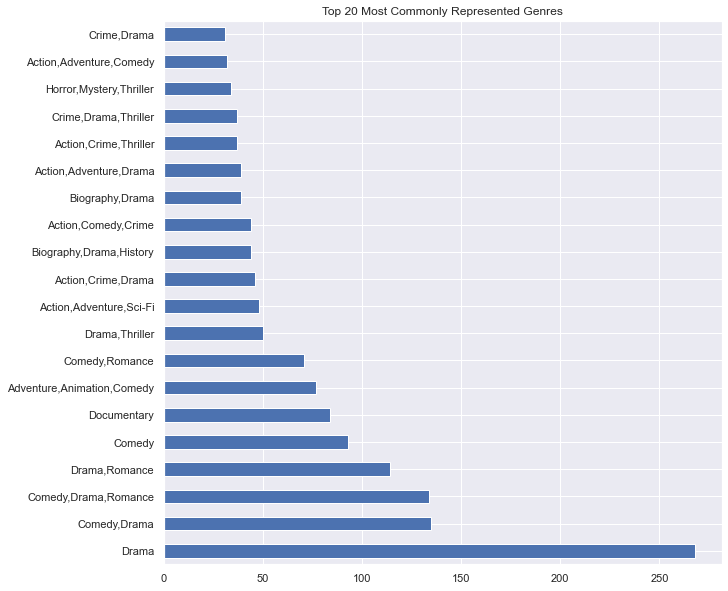

In [162]:
# Lets see what genres are more represented in the data 
fig, axs = plt.subplots(figsize=(10,10))
combined[combined['numvotes'] >= 62].genres.value_counts()[:20].plot.barh(ax=axs)
axs.set_title('Top 20 Most Commonly Represented Genres')

In [163]:
# Lets take a look at the value counts again 
combined['genres'].value_counts().head(20)

Drama                         333
Comedy,Drama                  142
Comedy,Drama,Romance          136
Drama,Romance                 118
Documentary                   115
Comedy                        101
Adventure,Animation,Comedy     77
Comedy,Romance                 76
Drama,Thriller                 56
Action,Adventure,Sci-Fi        48
Action,Crime,Drama             46
Biography,Drama,History        44
Action,Comedy,Crime            44
Action,Crime,Thriller          39
Biography,Drama                39
Action,Adventure,Drama         39
Crime,Drama,Thriller           39
Horror,Mystery,Thriller        34
Crime,Drama                    33
Action,Adventure,Comedy        33
Name: genres, dtype: int64

In [164]:
# To not skew our groupbys with genres represented a small amount of times, lets filter those out
combined_100 = combined.groupby("genres").filter(lambda x: len(x) > 30)

In [165]:
# Lets save the medians 
medians = combined_100.groupby('genres').median()

In [166]:
medians

,domestic_gross,foreign_gross,year,total_gross,averagerating,numvotes
genres,,,,,,
"Action,Adventure,Comedy",33.6000,163.600000,2016.0,205.618100,6.20,77234.0
"Action,Adventure,Drama",34.9000,62.300000,2014.0,77.900000,6.10,63787.0
"Action,Adventure,Fantasy",61.7000,221.600000,2016.0,334.900000,6.50,218371.0
"Action,Adventure,Sci-Fi",167.7500,297.850000,2014.0,563.400000,6.90,383706.5
"Action,Comedy,Crime",27.6000,25.800000,2014.0,52.954724,6.15,40016.5
"Action,Crime,Drama",9.8000,11.400000,2014.0,19.938000,6.55,38314.5
"Action,Crime,Thriller",17.6000,10.800000,2014.0,24.999503,6.50,48427.0
"Adventure,Animation,Comedy",90.3000,152.200000,2015.0,246.299999,6.50,47294.0
"Biography,Drama",3.0000,4.405122,2015.0,8.157732,6.90,16593.0


Text(0, 0.5, 'Genres')

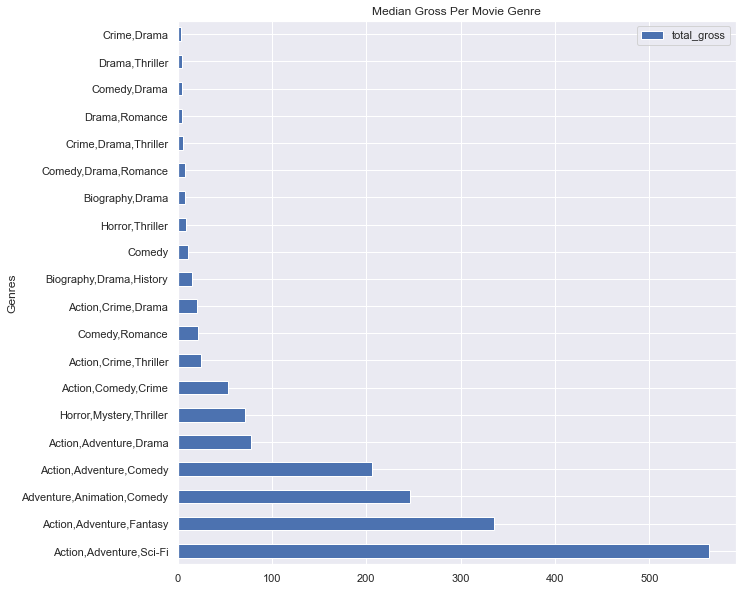

In [170]:
# Lets plot the median gross per genre of movie
fig, axs = plt.subplots(figsize=(10,10))
medians.reset_index().sort_values(by='total_gross', ascending=False)[:-2].plot.barh('genres', 'total_gross', ax=axs)
axs.set_title('Median Gross Per Movie Genre')
axs.set_ylabel('Genres')

Text(0.5, 1.0, 'Median Rating per Genre')

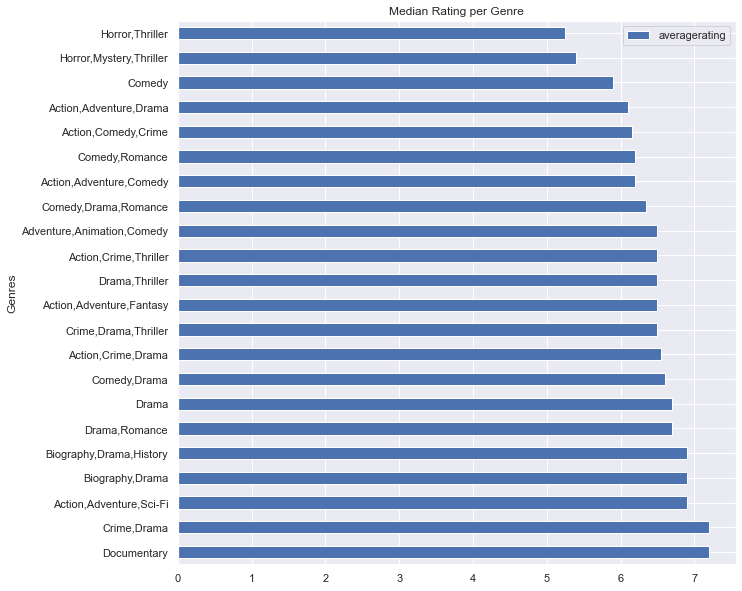

In [180]:
# Lets plot the median rating per genre of movie now that the data is combined for consistency
fig, axs = plt.subplots(figsize=(10,10))
medians.reset_index().sort_values(by='averagerating', ascending=False).plot.barh('genres', 'averagerating', ax=axs)
axs.set_ylabel('Genres')
axs.set_title('Median Rating per Genre')

In [173]:
# Lets also get the count of each genre now that the dataframes are merged
genre_list = list(medians.sort_values(by='averagerating', ascending=False).index)
genre_count = {}
for genre in genre_list:
    split = genre.split(',')
    for word in split:
        if word in genre_count:
            genre_count[word] += 1
        else:
            genre_count[word] = 1

In [174]:
# Lets see which genre is most represented in this setting
print(genre_count)
max(genre_count, key=genre_count.get)

{'Documentary': 1, 'Crime': 5, 'Drama': 11, 'Action': 7, 'Adventure': 5, 'Sci-Fi': 1, 'Biography': 2, 'History': 1, 'Romance': 3, 'Comedy': 7, 'Thriller': 5, 'Fantasy': 1, 'Animation': 1, 'Horror': 2, 'Mystery': 1}


'Drama'

In [175]:
# Lets combine our first analysis and only look at movies from the highest grossing studio BV
best_studio = combined_100[combined_100['studio'] == 'BV']

In [176]:
print(f'Number of movies from this studio {len(best_studio)}')
best_studio['genres'].value_counts()

Number of movies from this studio 56


Adventure,Animation,Comedy    19
Action,Adventure,Sci-Fi        9
Action,Adventure,Fantasy       7
Documentary                    5
Action,Adventure,Comedy        5
Comedy,Drama                   3
Drama                          3
Crime,Drama                    1
Action,Crime,Thriller          1
Biography,Drama,History        1
Drama,Romance                  1
Comedy,Romance                 1
Name: genres, dtype: int64

In [177]:
# Lets see which genres in our best performing studio grossed the most on average
best_studio.groupby('genres').mean()['total_gross'].sort_values(ascending=False)

genres
Action,Adventure,Sci-Fi       889.311263
Crime,Drama                   857.600000
Action,Adventure,Fantasy      746.414286
Action,Adventure,Comedy       726.600000
Adventure,Animation,Comedy    595.436842
Biography,Drama,History       275.300000
Action,Crime,Thriller         203.300000
Drama                         142.276977
Documentary                    61.502200
Comedy,Drama                   57.143643
Comedy,Romance                 43.100000
Drama,Romance                  25.900000
Name: total_gross, dtype: float64

Text(0, 0.5, 'Genres')

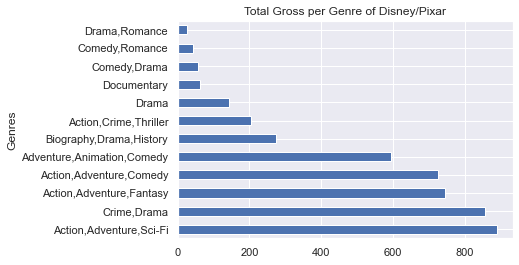

In [178]:
fig, axs = plt.subplots()
best_studio.groupby('genres').mean()['total_gross'].sort_values(ascending=False).plot.barh(ax=axs)
axs.set_title('Total Gross per Genre of Disney/Pixar')
axs.set_ylabel('Genres')

Potential Recommendation: If the company values only total gross, they should look into making an adventure or action movie. If they care about following a well credited studio they should look into making Crime or Horror

## T-test
We want to know if animation movies gross more internationally or domestically. We chose animation because it is the genre that is the 2nd most occurring in highest rated movies and is appears in highly grossing films from our best studio. Our Null Hypothesis would be that the animation genre grosses the same internationally and domestically while our alternative hypothesis would be that animation movies gross more internationally than domestically. Based on the results of this test we can advise our client where to focus their marketing efforts 

In [202]:
# First, lets get the dataframe of only animation movies 
genre_to_grab = "Animation"

ttest_df = combined[combined['genres'].str.contains(genre_to_grab)][['domestic_gross', 'foreign_gross']]


In [203]:
# Lets check to see if we have enough samples
len(ttest_df)

159

In [204]:
# Lets look at the statistics to give us a basis for our intution
ttest_df.describe()

,domestic_gross,foreign_gross
count,159.000000,159.000000
mean,89.131074,164.672467
std,111.552661,199.679024
min,0.000600,0.000979
25%,0.889000,9.781427
50%,48.000000,75.900000
75%,145.950000,276.900000
max,608.600000,875.700000


In [205]:
# Lets sample from our data
domestic_sample = ttest_df['domestic_gross'].sample(100)
foreign_sample = ttest_df['foreign_gross'].sample(100)

In [206]:
# Lets perform a one tailed two sample t test
import scipy.stats as stats
alpha = .05
tstat, pvalue = stats.ttest_ind(domestic_sample, foreign_sample, equal_var=False)

answer = 'Reject null hypothesis' if pvalue < alpha else 'Fail to reject null hypothesis'
print(answer)

Reject null hypothesis


In [207]:
pvalue

0.0008266479347858674

After performing the hypothesis test, we can conclude that there is a significant difference between the mean of foreign and domestic gross in favor of foreign. Thus we can focus our marketing efforts there 

In [168]:
tstat

-3.4016714178955993

Text(0.5, 1.0, 'T-Distribution w/D.F = 99')

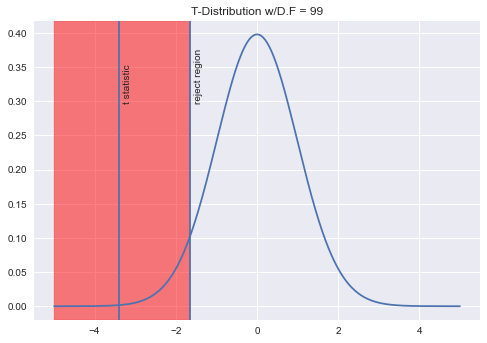

In [180]:
# Plot the t statistic on a t distribution
tval_alpha = stats.t.ppf(.05, 99)
x = np.linspace(-5,5,1000)
y = stats.t.pdf(x, 99)
fig, axs = plt.subplots()
axs.plot(x,y)
axs.axvline(tstat)
axs.axvline(tval_alpha)
axs.axvspan(-5, tval_alpha, alpha=0.5, color='red')
plt.text(tval_alpha + .1 ,.3,'reject region',rotation=90)
plt.text(tstat + .1 ,.3,'t statistic',rotation=90)
axs.set_title('T-Distribution w/D.F = 99')

# Luis Estrada 

# Kilmar Lazo 

# Michael Eugene

In [141]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np

movie_gross_df = pd.read_csv('zippedData/bom.movie_gross.csv.gz')
                              
movie_info_df = pd.read_csv('zippedData/rt.movie_info.tsv.gz', delimiter= '\t')
                            
reviews_df = pd.read_csv('zippedData/rt.reviews.tsv.gz', delimiter='\t', encoding = 'latin')

movies_df = pd.read_csv('zippedData/tmdb.movies.csv.gz')
                            
movie_budgets_df = pd.read_csv("zippedData/tn.movie_budgets.csv.gz",index_col=0)

conn = sqlite3.connect('zippedData/im.db')

In [142]:
df = movie_budgets_df

In [143]:
movie_budgets_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5782 entries, 1 to 82
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   release_date       5782 non-null   object
 1   movie              5782 non-null   object
 2   production_budget  5782 non-null   object
 3   domestic_gross     5782 non-null   object
 4   worldwide_gross    5782 non-null   object
dtypes: object(5)
memory usage: 271.0+ KB


## Data Cleaning

removing the commas and dollar signs from the columns so that it would easier to do calculations.

In [144]:
df = df.apply(lambda x: x.str.replace(',',''))
df['domestic_gross'] = df['domestic_gross'].fillna(0.0).str.replace('[$,]', '').astype('float')

In [145]:
df['domestic_gross'] = df['domestic_gross'].replace(',', '')
df['domestic_gross'] = df['domestic_gross'].replace('$', '')


In [146]:
df['production_budget'] = df['production_budget'].str.replace(',', '')
df['production_budget'] = df['production_budget'].str.replace('$', '')


In [147]:
df = df.apply(lambda x: x.replace('$',''))
df['production_budget'] = df['production_budget'].fillna(0.0).replace('[$,]', '').astype('float')

In [148]:
df = df.apply(lambda x: x.replace('$',''))
df['worldwide_gross'] = df['worldwide_gross'].fillna(0.0).replace('[$,]', '').astype('float')

ValueError: could not convert string to float: '$2776345279'

In [ ]:
df['worldwide_gross'] = df['worldwide_gross'].str.replace(',', '')
df['worldwide_gross'] = df['worldwide_gross'].str.replace('$', '')


## Data exploration 

Taking a look at the top 15 movies with the highest production budget

In [ ]:
sorted_df=df.sort_values(by ='production_budget', ascending = False)
sorted_df.head()

,release_date,movie,production_budget,domestic_gross,worldwide_gross
id,,,,,
1,Dec 18 2009,Avatar,425000000.0,760507625.0,2.776345e+09
2,May 20 2011,Pirates of the Caribbean: On Stranger Tides,410600000.0,241063875.0,1.045664e+09
3,Jun 7 2019,Dark Phoenix,350000000.0,42762350.0,1.497624e+08
4,May 1 2015,Avengers: Age of Ultron,330600000.0,459005868.0,1.403014e+09
5,Dec 15 2017,Star Wars Ep. VIII: The Last Jedi,317000000.0,620181382.0,1.316722e+09


In [ ]:
my_fn =lambda x:float(x.replace(',',''))

Looking at the movies with the highest domestic_ gross

In [ ]:
sorted_df=df.sort_values(by ='domestic_gross', ascending = False)
sorted_df.head()

,release_date,movie,production_budget,domestic_gross,worldwide_gross
id,,,,,
6,Dec 18 2015,Star Wars Ep. VII: The Force Awakens,306000000.0,936662225.0,2.053311e+09
1,Dec 18 2009,Avatar,425000000.0,760507625.0,2.776345e+09
42,Feb 16 2018,Black Panther,200000000.0,700059566.0,1.348258e+09
7,Apr 27 2018,Avengers: Infinity War,300000000.0,678815482.0,2.048134e+09
43,Dec 19 1997,Titanic,200000000.0,659363944.0,2.208208e+09


Looking the movies with highest worldwide_gross

In [ ]:
sorted_df=df.sort_values(by ='worldwide_gross', ascending = False)
sorted_df.head()

,release_date,movie,production_budget,domestic_gross,worldwide_gross
id,,,,,
1,Dec 18 2009,Avatar,425000000.0,760507625.0,2.776345e+09
43,Dec 19 1997,Titanic,200000000.0,659363944.0,2.208208e+09
6,Dec 18 2015,Star Wars Ep. VII: The Force Awakens,306000000.0,936662225.0,2.053311e+09
7,Apr 27 2018,Avengers: Infinity War,300000000.0,678815482.0,2.048134e+09
34,Jun 12 2015,Jurassic World,215000000.0,652270625.0,1.648855e+09


In [ ]:
sorted_df=df.sort_values(by ='worldwide_gross', ascending = False).mean()
sorted_df.head(10)

production_budget    3.158776e+07
domestic_gross       4.187333e+07
worldwide_gross      9.148746e+07
dtype: float64

In [ ]:
my_fn =lambda x:float(x)


Ordering movies by the year 

In [ ]:
df['release_date'] = pd.to_datetime(df['release_date']).dt.year
df.head()

,release_date,movie,production_budget,domestic_gross,worldwide_gross
id,,,,,
1,2009,Avatar,425000000.0,760507625.0,2.776345e+09
2,2011,Pirates of the Caribbean: On Stranger Tides,410600000.0,241063875.0,1.045664e+09
3,2019,Dark Phoenix,350000000.0,42762350.0,1.497624e+08
4,2015,Avengers: Age of Ultron,330600000.0,459005868.0,1.403014e+09
5,2017,Star Wars Ep. VIII: The Last Jedi,317000000.0,620181382.0,1.316722e+09


In [ ]:
sorted_df=df.sort_values(by ='release_date', ascending = False)
sorted_df.head()

,release_date,movie,production_budget,domestic_gross,worldwide_gross
id,,,,,
95,2020,Moonfall,150000000.0,0.0,0.0
36,2020,Call of the Wild,82000000.0,0.0,0.0
6,2020,Hannibal the Conqueror,50000000.0,0.0,0.0
30,2019,Unhinged,29000000.0,0.0,0.0
71,2019,PLAYMOBIL,75000000.0,0.0,0.0


Mean of the top 300 grossing movies worldwide

In [ ]:
sorted_df.sort_values(by = 'worldwide_gross', ascending=False)['worldwide_gross'][:300].mean()

685175373.19

Mean of the top 300 grossing movies production budget.

In [ ]:
sorted_df.sort_values(by = 'worldwide_gross', ascending=False)['production_budget'][:300].mean()

134329408.73

## Visualization 

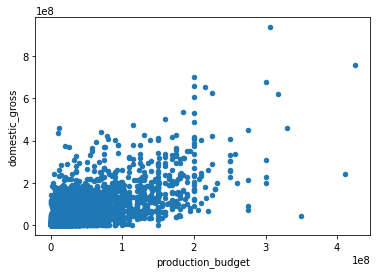

In [ ]:
df.plot.scatter(x = 'production_budget', y = 'domestic_gross', s = 20);


Looking at the correlation between budget and gross

In [ ]:
np.corrcoef(sorted_df['production_budget'], sorted_df['worldwide_gross'])[0][1]

0.7483059765694757

Top 30 years that producted the most movies.

<AxesSubplot:>

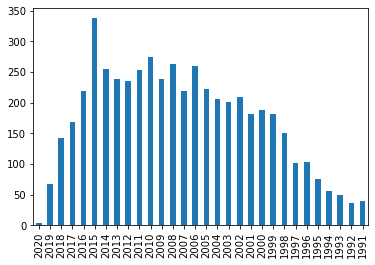

In [ ]:
sorted_df['release_date'].value_counts().sort_index(ascending=False)[:30].plot.bar()

Looking at how many movies came per year since 2000

In [ ]:
sorted_df = sorted_df[sorted_df['release_date'] > 2000]

In [ ]:
sorted_df['release_date'].value_counts()
df.head()

,release_date,movie,production_budget,domestic_gross,worldwide_gross
id,,,,,
1,2009,Avatar,425000000.0,760507625.0,2.776345e+09
2,2011,Pirates of the Caribbean: On Stranger Tides,410600000.0,241063875.0,1.045664e+09
3,2019,Dark Phoenix,350000000.0,42762350.0,1.497624e+08
4,2015,Avengers: Age of Ultron,330600000.0,459005868.0,1.403014e+09
5,2017,Star Wars Ep. VIII: The Last Jedi,317000000.0,620181382.0,1.316722e+09


Taking a look at meadian movie gross 

<AxesSubplot:xlabel='release_date', ylabel='worldwide_gross'>

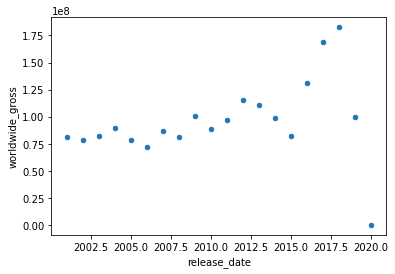

In [ ]:
sorted_df.groupby('release_date').mean().reset_index().plot.scatter('release_date', 'worldwide_gross')